# Modelagem e Simulação de uma Operação de Filtração em  Batelada

por [Afrânio Melo](http://afrjr.weebly.com) (t.c.c. Afra)

[afraeq@gmail.com](mailto:afrjr3@gmail.com)


07/2017

### Resumo

Neste [notebook Jupyter](http://jupyter.org/), estudaremos a operação unitária de filtração, explorando passo-a-passo o processo de modelagem e simulação computacional da operação de um filtro industrial do tipo prensa. Contextualizaremos o procedimento utilizando o processo de extração de óleo de grãos de amendoim. Para operação do filtro, é necessária uma bomba, e os parâmetros da curva característica dessa bomba serão estimados a partir de dados reais, fornecidos no catálogo da fabricante [Grainger Industrial Supply](http://www.grainger.com/). Para simular a operação, integraremos a famosa *equação de trabalho da filtração em superfície* de modo a calcular o volume de filtrado produzido ao longo do tempo, ou seja, preveremos a produção do filtro a partir de simulação computacional.

As técnicas numéricas ilustradas neste *notebook* incluem integração de equações diferenciais ordinárias, resolução de equações não-lineares e estimação de parâmetros. Os códigos estão escritos na linguagem [Python 3.6](https://www.python.org/) e utilizam as bibliotecas [NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) e [Matplotlib](https://matplotlib.org/).

<img src="https://i.ibb.co/J3PDL2Q/press1-2.jpg" width="600" height="500" />

## 1. Contextualização 

Imagine-se como engenheira química e de alimentos de uma pequena indústria indiana (já que tá difícil até imaginar um emprego no Brasil..). Você é a responsável pela implementação de um processo de extração de óleo de amendoim a partir de seus grãos. 

Dentre as várias possibilidades analisadas, a que mais lhe interessou foi um processo em duas etapas:

1. os grãos são moídos, resultando em uma suspensão (mistura sólido+líquido);

2. a suspensão resultante é enviada, por meio de uma bomba, a um filtro-prensa, onde óleo e resíduos sólidos são separados.

Difícil imaginar? O vídeo abaixo ilustra exatamente o processo descrito.

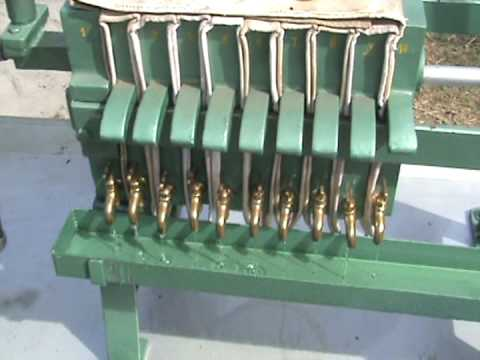

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("iUaU_KYltlA")

O plano é aproveitar equipamentos atualmente inoperantes no almoxarifado da pequena indústria, a saber: um velho filtro-prensa de placas e quadros com 10 quadros de área 0,05 m$^2$ cada e uma bomba centrífuga *Dayton* modelo 2ZXA1, comprada da [Grainger Industrial Supply](https://www.grainger.com/). 

O processo ainda não foi implementado, mas você pediu para o estagiário realizar um ensaio preliminar em laboratório com um pequeno filtro-folha de testes que indicou os seguintes resultados:

* resistividade da torta de filtração: 9 x 10$^{10}$ m/kg;
* resistência do meio filtrante: 0 (desprezível);
* densidade do filtrado:  800 kg/m$^3$;
* viscosidade do filtrado: 0,002 kg/m$\cdot$s. 

Verificou-se também que a concentração média de sólidos do amendoim moído é de 1,3 kg de sólidos/kg de líquido.

Sua tarefa agora é ordenar ao estagiário que simule em computador a etapa de filtração por meio do cálculo do volume de filtrado produzido (óleo) em função do tempo, ao longo de 30 minutos.

E agora?? Como será que o pobre estudante vai se virar? Será que sua simulação vai rodar? Será que o processo planejado vai ser implementado? Serão os dois funcionários sumariamente demitidos? Generosamente promovidos? De modo a conhecer o final dessa história, precisamos aprender mais sobre a filtração, aprender o que significam todos esses dados referentes ao ensaio de teste e, o mais excitante, precisamos aprender a simular a operação!

## 2 . Filtração - Conceitos básicos

### 2.1 - Filtração em superfície - o filtro-prensa

A filtração é uma das operações unitárias mais importantes da indústria de processos. Aplicável a suspensões sólido+fluido, se refere à separação mecânica entre as fases sólida e fluida presentes na suspensão, utilizando-se um meio poroso que é permeável à fase fluida e  retém a fase sólida. A esse meio poroso damos o nome de *meio filtrante*. O fluido que atravessa o meio filtrante é denominado de *filtrado*.

Dos vários tipos de filtração industrial existentes, o que nos interessa aqui é a *filtração em superfície* ou *filtração com formação de torta.* Nesse tipo de filtração, à medida que a suspensão atravessa o meio filtrante (que é necessariamente bem fino), as partículas retidas formam um depósito sobre a superfície do meio filtrante. Esse depósito é conhecido como *torta*. Conforme a torta vai ficando cada vez mais espessa com o passar do tempo, mais é a própria torta a principal responsável pela retenção das partículas durante a operação.

A figura abaixo ilustra o mecanismo de filtração em superfície, utilizando como meio filtrante um material cerâmico poroso.

<img src="http://www.induceramic.com/_/rsrc/1472778318242/porous-ceramics-application/filtration-separation-application/surface%20filtration%20figure%20.jpg?height=308&width=400" /> 

Dos vários tipos de filtros que operam por esse mecanismo, o que será usado em nosso processo é o *filtro-prensa*. Esse tipo de filtro é formado por dois elementos, as *placas* e os *quadros*, posicionados alternadamente e separados pelo meio filtrante (em geral um tecido, papel, etc). O nome *prensa* vem do fato de que quadros e placas são firmemente prensados uns contra os outros, como ilustrado a seguir.

<img src="http://csmres.co.uk/cs.public.upd/article-images/Fig-3---SB_with_plates_colour1.jpg" /> 



Os quadros são caixas sem tampa e sem fundo nas quais se forma a torta de filtração. As placas são ranhuradas de modo a permitir a circulação de líquido entre placa e meio filtrante. O mecanismo de operação do filtro-prensa está muito bem ilustrado nos vídeos a seguir:

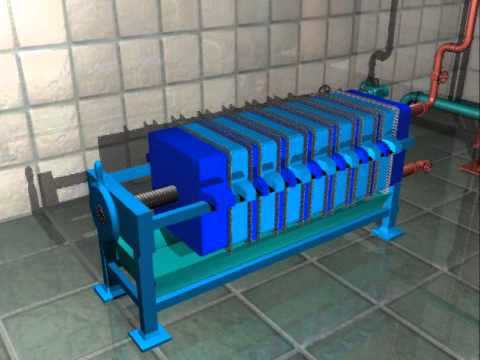

In [2]:
YouTubeVideo("Nx6CaKe4gcg")

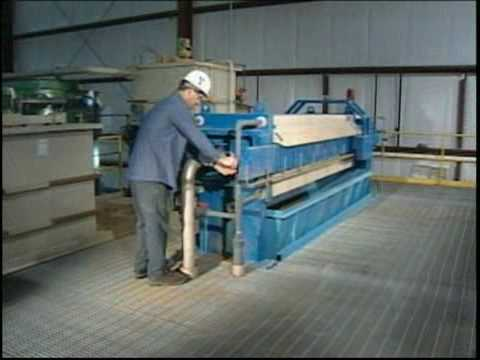

In [3]:
YouTubeVideo("Eo8ce3_V6ic")

O filtro-prensa opera em batelada. A produção vai diminuindo com o passar do tempo até que chega um momento em que a operação precisa ser interrompida. A torta de filtração então é retirada e um novo ciclo começa. 

Para mais detalhes sobre filtros industriais, clique [aqui](https://drive.google.com/file/d/0B2327zMqaoikdkNmS3E1SkxGYTA/view), e para mais vídeos sobre filtração, [aqui](http://afrjr.weebly.com/filtros-industriais.html).

### 2.2 - O modelo - Equação de trabalho da filtração em superfície

De modo a simular a operação do filtro, precisamos de um modelo matemático que descreva a evolução da produção de filtrado com o passar do tempo.

Esse modelo é fornecido pela *equação de trabalho da filtração em superfície*:

$$\frac{dV}{dt} = \frac{1}{2B_1V+B_2}$$

sendo:

$$B_1 = \displaystyle\frac{\alpha\mu\rho C}{2 A^2 \Delta P}$$

 
$$B_2 = \displaystyle\frac{\mu R_m}{A \Delta P}$$

A dedução da equação de trabalho, que usa conceitos da mecânica do contínuo (uma espécie de fusão entre mecânica dos fluidos e mecânica dos sólidos), pode ser encontrada em [PEÇANHA, 2014](https://books.google.com.br/books/about/Sistemas_Particulados.html?id=4JeoBQAAQBAJ&printsec=frontcover&source=kp_read_button&redir_esc=y#v=onepage&q&f=false). Repare que trata-se de uma equação diferencial ordinária (EDO). Resolvê-la, portanto, significa encontrar a função $V(t)$ cuja derivada $dV/dt$ satisfaça a equação.

Os termos da equação são:

* $V$, volume de filtrado produzido;

* $t$, tempo;

* $dV/dt$, vazão instantânea de filtrado;

* $\alpha$, resistividade da torta, uma medida da dificuldade com que ocorre o escoamento através da torta;

* $\mu$, viscosidade do filtrado;

* $\rho$, densidade do filtrado;

* $C$, concentração de sólidos da suspensão (massa de sólido/massa de líquido);

* $A$, área total de filtração;

* $\Delta P$, queda de pressão da filtração;

* $R_m$, resistência do meio filtrante, uma medida da dificuldade com que ocorre o escoamento através do meio filtrante.

Em geral, para fins de simulação do filtro industrial, os termos $\alpha$ e $R_m$ são medidos em laboratório, utilizando um filtro menor, chamado de filtro de testes. Foi o que fez o estagiário da nossa história, lembra?

Como a suspensão é forçada a escoar através do filtro por meio de uma bomba, a queda de pressão da filtração $\Delta P$ é igual à queda de pressão da bomba. Se você der uma conferida no seu caderno antigo de MecFlu, vai encontrar uma equação que relaciona a queda de pressão com a carga da bomba:

$$\Delta P = \rho g H$$

sendo $g$ a aceleração da gravidade e $H$, a carga da bomba. Lembre-se de que carga, em engenharia (para desespero dos físicos), se refere a uma forma de expressar energia com dimensões de altura.

E como determinar a tal carga da bomba $H$? Para isso, precisamos da *curva característica da bomba*, uma relação entre carga e vazão de líquido bombeado, $H$ X $Q$ (no caso, $Q = dV/dt$, por definição). Essa curva é fornecida pelo fabricante da bomba.

Portanto, para simular a operação, precisamos:

* obter a curva característica da bomba, de modo a determinar uma expressão para $\Delta P$;

* resolver a equação de trabalho da filtração. O resultado final será a função $V(t)$, ou seja, exatamente o que queremos: a produção de filtrado com o passar do tempo.

Agora chega de papo e vamos simular.



## 3. Simulação

### 3.1. Etapa 1: preparação do código

O primeiro passo é importar os módulos necessários e definir os dados que são conhecidos.

In [4]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import ode
import matplotlib.pyplot as plt
%matplotlib inline

# gravidade
g = 9.81

# densidade e viscosidade do filtrado
mu = 0.002
rho = 800

# concentração de sólidos na suspensão
C = 1.3

# área total do filtro
A = 2*10*0.05

# resistividade da torta e resistência do meio filtrante
alpha = 9e10
Rm = 0

Todos os dados estão no Sistema Internacional de Unidades. Perceba que a área total do filtro corresponde ao dobro da área de cada quadro (correspondente aos dois lados de cada quadro) multiplicada pelo número de quadros.

### 3.2. Etapa 2: obtenção da curva da bomba

Agora iremos obter uma expressão para a curva característica da bomba *Dayton* modelo 2ZXA1. Você pode encontrar os dados de vazão *vs.* carga da bomba no [catálogo do fabricante](https://www.grainger.com/product/DAYTON-Bronze-1-HP-Centrifugal-Pump-2ZXA1). 

Os dados do catálogo são fornecidos na forma de pontos discretos $(H,Q)$. No entanto, para fins da nossa simulação, precisamos da expressão de uma função $H = H(Q)$. Ou seja, temos de encontrar uma expressão $H = H(Q)$ para a curva da bomba que represente bem o conjunto de pontos $(H,Q)$ disponíveis.

Abaixo, os dados do catálogo são armazenados em vetores e convertidos para o Sistema Internacional de Unidades:

In [5]:
H_ft = np.array([10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110])
Q_GPM = np.array([59, 57, 55, 53, 51, 47, 43, 38, 34, 28, 23, 13, 3])

Q = Q_GPM/15850.372483753;
H = H_ft*0.3048;

print(Q)
print(H)

[ 0.00372231  0.00359613  0.00346995  0.00334377  0.00321759  0.00296523
  0.00271287  0.00239742  0.00214506  0.00176652  0.00145107  0.00082017
  0.00018927]
[  3.048   4.572   6.096   7.62    9.144  12.192  15.24   18.288  21.336
  24.384  27.432  30.48   33.528]


Que tal plotarmos os dados e darmos uma olhada em sua tendência, de modo a decidir que tipo de função passar sobre os pontos?

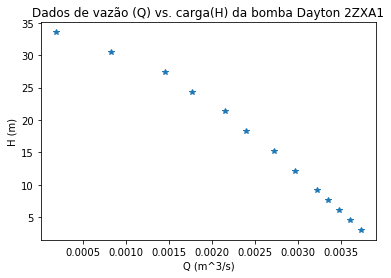

In [6]:
plt.plot(Q,H,'*')
plt.title('Dados de vazão (Q) vs. carga(H) da bomba Dayton 2ZXA1')
plt.xlabel('Q (m^3/s)')
plt.ylabel('H (m)')

Hmm, parece que uma parábola pode fazer um belo trabalho passando por esses pontos... O que você acha?

A seguir, utilizamos a função *polyfit* da biblioteca *NumPy* para estimar os coeficientes da parábola que melhor ajusta os dados:

In [7]:
# grau do polinômio a ser ajustado (parábola!)
n = 2

# ajustando o polinômio
c = np.polyfit(Q,H,n) 
print(c)

[ -1.48474313e+06  -2.93263608e+03   3.41839257e+01]


Show! Acabamos de obter os coeficientes da dita parábola. Agora, vamos plotá-la, em conjunto com os dados, de modo a conferir visualmente a qualidade da estimação.

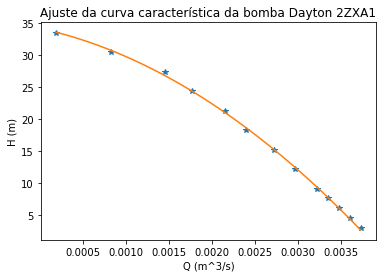

In [8]:
# domínio de Q ''continuo'' (para plotar a curva)
Qc = np.linspace(Q[-1],Q[0],50)

# plotando
plt.plot(Q,H,'*',Qc,c[2]+c[1]*Qc+c[0]*Qc**2,'-')
plt.title('Ajuste da curva característica da bomba Dayton 2ZXA1')
plt.xlabel('Q (m^3/s)')
plt.ylabel('H (m)')

*Voilà*! Ficou bonito, né?

A Etapa 1 está concluída. Obtida a expressão para a curva característica da bomba, vamos inseri-la na equação de trabalho da filtração, de modo a finalmente simular a operação.  

### 3.3. Etapa 3: simulação propriamente dita

Lembrando: nosso objetivo é resolver a equação diferencial:

$$\frac{dV}{dt} = \frac{1}{2B_1V+B_2}$$

sendo:

$$B_1 = \displaystyle\frac{\alpha\mu\rho C}{2 A^2 \Delta P}$$

 
$$B_2 = \displaystyle\frac{\mu R_m}{A \Delta P}$$


$$\Delta P = \rho g H = \rho g [a + b\, dV/dt + c \,(dV/dt)^2]
$$

com $a$, $b$ e $c$ representando os coeficientes da parábola que foi ajustada à curva característica da bomba. Lembre-se de que, por definição, $Q = dV/dt$, o que explica a presença de $dV/dt$ na expressão de $\Delta P$.

Para resolver uma equação diferencial com a biblioteca NumPy e o *solver* que utilizaremos (*dopri5*), é preciso definir uma função em Python que aceite como argumentos $t$ e $V$ e retorne $dV/dt$.

Note que a expressão de $dV/dt$ contém $\Delta P$ que, por sua vez, também depende de $dV/dt$. Não é possível, portanto, o simples isolamento do termo $dV/dt$, o que faz com que a expressão de $dV/dt$ constitua uma *equação não-linear*. Sendo assim, para determinar o valor de $dV/dt$, precisamos utilizar um *solver* de equações não-lineares. Esse *solver* (no caso, *fsolve*) é invocado dentro da função que retorna $dV/dt$, como pode ser observado abaixo.

In [9]:
# function que define a equação de trabalho    
def dVdt(t,V):
    deltaP = lambda q: (rho*g*(c[2]+c[1]*q+c[0]*q**2))
    solve_dVdt = lambda q : (1/q-(mu/(A*deltaP(q)))*alpha*rho*C*V/A+Rm)
    return opt.fsolve(solve_dVdt,1e-3)

Outro detalhe a se ressaltar é o fato de que $dV/dt$ depende apenas de $V$ e não de $t$. Apesar disso, no código, a função é escrita como dependente de $t$ e $V$ (nessa ordem!), um requerimento necessário para compatibilidade com o *solver* de EDO's *dopri5*. 

Agora é hora de finalmente resolver a equação de trabalho! O primeiro passo é definir a condição inicial e o tempo final de simulação:

In [10]:
# condição inicial
t0 = 0
V0 = 1e-8

# tempo final
tf = 1800

O volume inicial é um número muito pequeno, porém não nulo, para evitar problemas no ponto inicial da integração.

As linhas seguintes preparam o *solver* com a equação diferencial a ser resolvida, o integrador a ser utilizado (*dopri5*, que utiliza um método numérico explícito do tipo Range-Kutta), as condições iniciais e a função (chamada *solout*) responsável por armazenar os resultados na lista *solucao*: 

In [11]:
# preparando o integrador

solver = ode(dVdt)

solver.set_integrator('dopri5')
solver.set_initial_value(V0, t0)

solucao = []
def solout(t, y):
    solucao.append([t, *y])
solver.set_solout(solout)

E agora, finalmente... simulando a operação!!

In [12]:
# rodando a simulação!
solver.integrate(tf)

/Users/afranio/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


array([ 0.07169749])

*Success*! Volume final de filtrado $V_f = 0{,}07169749$ m$^3$.

Como nota-se pela mensagem acima, o integrador experimentou um problema pontual em uma das iterações, no *fsolve*, o que não parece ter influenciado o andamento dos cálculos. Apesar disso, em um contexto que demandasse mais acurácia, seria boa prática investigar as causas dessa mensagem com mais detalhes.

Sei que você está ansiosa para conferir o gráfico que mostra a evolução no tempo do volume de óleo filtrado $V(t)$, então lá vai...

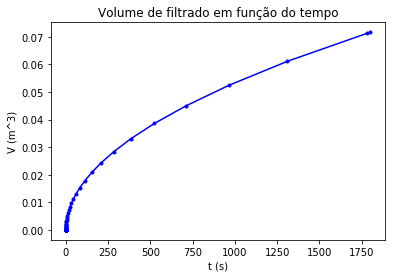

In [13]:
# plotando
solucao = np.array(solucao)
plt.plot(solucao[:,0], solucao[:,1], 'b.-')
plt.title('Volume de filtrado em função do tempo')
plt.xlabel('t (s)')
plt.ylabel('V (m^3)')

E é isso! Simulação completa!


# 4 - Conclusão

E quanto à nossa historieta? Que moral levar para casa depois de todo esse aprendizado?

Pois bem, o estagiário (após algumas madrugadas perdidas e disciplinas abandonadas) conseguiu simular a operação, do jeitinho que aprendemos aqui. A engenheira apresentou os resultados ao seu superior imediato, que logicamente adorou e mandou que implementassem o processo o quanto antes. Ordem que foi prontamente atendida pelo estagiário, com ainda mais afinco do que o normal, já que seu período letivo estava mesmo todo perdido. Ao fim de um ano, as vendas de óleo de amendoim estavam tão em alta que a engenheira foi promovida e o estagiário, contratado em seu lugar!

Moral da história: na Índia, os engenheiros químicos são empregados e prestigiados. Tão prestigiados que lá até Deus é considerado um Engenheiro Químico (como vocês podem conferir na palestra TED abaixo).

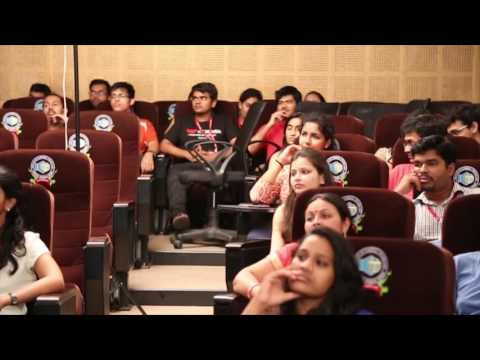

In [14]:
YouTubeVideo("viGTk_2Q-L4")

(o que é muito razoável. Se lá as vacas são sagradas, por que não a gente?)

<div style="text-align: right"> Afra </div>


## Referência

[PEÇANHA, R.P. - Sistemas Particulados # Operações Unitárias Envolvendo Partículas e Fluidos - Elsevier, 2014](https://books.google.com.br/books/about/Sistemas_Particulados.html?id=4JeoBQAAQBAJ&printsec=frontcover&source=kp_read_button&redir_esc=y#v=onepage&q&f=false).